In [ ]:
## AGENDA
## - Link prediction

In [ ]:
## SET LIBRARY

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx

/Users/boO/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'figure.figsize': (7.5, 7.5),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

In [ ]:
## SET WORK PATH

In [3]:
#work_path = '/home/dmig/work/this-book/neo4j-book'
work_path = '/Users/boO/data8/data.student/neo4j-book/neo4j-book'
os.chdir(work_path)

In [ ]:
#from py2neo import Graph
#graph = Graph("bolt://neo4j.sktai.io:30074", auth=("neo4j","!neo4j00"))

In [ ]:
# https://github.com/neo4j-contrib/neo4j-apoc-procedures/releases/tag/3.5.0.1
#mv ./apoc-3.5.0.1-all.jar $Neo4J_HOME/plugins

In [ ]:
## SET GRAPH

In [4]:
from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [5]:
#gph_conn = Neo4jConnection(uri="bolt://neo4j.sktai.io:30074", user="neo4j", pwd="!neo4j00")
#gph_conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="!neo4j00")
gph_conn = Neo4jConnection(uri="bolt://127.0.0.1:7687", user="neo4j", pwd="!neo4j00")

In [6]:
gph_conn.query("""
               CALL db.schema()
               """)

[<Record nodes=[<Node id=-1 labels=frozenset({'member'}) properties={'indexes': [], 'name': 'member', 'constraints': []}>] relationships=[<Relationship id=-1 nodes=(<Node id=-1 labels=frozenset({'member'}) properties={'indexes': [], 'name': 'member', 'constraints': []}>, <Node id=-1 labels=frozenset({'member'}) properties={'indexes': [], 'name': 'member', 'constraints': []}>) type='LINKED_TO' properties={}>]>]

In [7]:
pd.DataFrame(gph_conn.query("""
               CALL apoc.meta.stats()
               """)).T.values

array([[1],
       [1],
       [2],
       [34],
       [78],
       [{'member': 34}],
       [{'()-[:LINKED_TO]->()': 78, '(:member)-[:LINKED_TO]->()': 78, '()-[:LINKED_TO]->(:member)': 78}],
       [{'LINKED_TO': 78}],
       [{'relTypeCount': 1, 'propertyKeyCount': 2, 'labelCount': 1, 'nodeCount': 34, 'relCount': 78, 'labels': {'member': 34}, 'relTypes': {'()-[:LINKED_TO]->()': 78, '(:member)-[:LINKED_TO]->()': 78, '()-[:LINKED_TO]->(:member)': 78}}]],
      dtype=object)

In [ ]:
gph_conn.query("""
          MATCH (n)
          DETACH DELETE n
          """)

In [ ]:
## LOAD DATA

In [8]:
gph = nx.karate_club_graph()
pos = nx.spring_layout(gph, k=0.3)

In [9]:
club_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
for node_id, club_id in zip(gph.nodes, club_ids):
    gph.nodes[node_id]['club'] = club_id

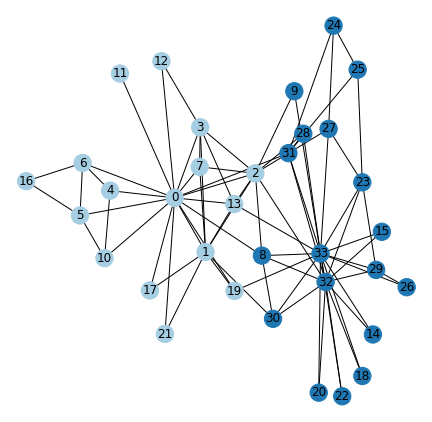

In [10]:
node_rgb = [sns.color_palette("Paired")[0] if gph.nodes[node_id]['club']==0 else sns.color_palette("Paired")[1] for node_id in gph]
nx.draw_networkx(gph, label=True, node_color=node_rgb)

In [ ]:
edge = nx.to_pandas_edgelist(gph)
edge.columns = [":START_ID",":END_ID"]
edge[':TYPE'] = 'LINKED_TO'
edge.to_csv("{}/data/edge_karate.csv".format(work_path), index=False)

In [ ]:
node = pd.DataFrame(nx.nodes(gph))
node.columns = ['id:ID']
node[':LABEL'] = 'member'
node['club'] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
node.to_csv("{}/data/node_karate.csv".format(work_path), index=False)

In [ ]:
!bin/neo4j-admin import --nodes=import/node_karate.csv --relationships=import/edge_karate.csv

In [ ]:
## via GDS

In [11]:
gph_conn.query("""
               CALL gds.graph.drop("graph")
               """)
gph_conn.query("""
               CALL gds.graph.create("graph", "member", {LINKED_TO: {type: 'LINKED_TO', orientation: 'UNDIRECTED'}})
               """)

Query failed: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.drop`: Caused by: java.lang.IllegalArgumentException: Graph with name `graph` does not exist and can't be removed.}


[<Record graphName='graph' nodeProjection={'member': {'properties': {}, 'label': 'member'}} relationshipProjection={'LINKED_TO': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'LINKED_TO', 'properties': {}}} nodeCount=34 relationshipCount=156 createMillis=34>]

In [ ]:
## DEEP WALK 

In [22]:
gph_conn.query("""
               MATCH (n:member {id: "0"}) 
               CALL gds.alpha.randomWalk.stream(
               {
                  nodeProjection: "*", 
                  relationshipProjection: { LINKED_TO: { type: "LINKED_TO", orientation: "UNDIRECTED" } }, 
                  start: id(n), walks: 2, steps: 32,
                  inOut: 0.2, return: 1.0
               }) 
               YIELD nodeIds 
               RETURN nodeIds
               """)

[<Record nodeIds=[0, 13, 3, 7, 1, 21, 1, 13, 3, 2, 13, 1, 3, 2, 7, 2, 28, 33, 8, 32, 29, 33, 29, 33, 20, 33, 32, 8, 30, 32, 20, 32, 2]>,
 <Record nodeIds=[0, 4, 0, 2, 28, 31, 25, 24, 31, 25, 24, 25, 31, 33, 9, 33, 15, 33, 19, 0, 6, 0, 10, 0, 5, 0, 19, 0, 4, 10, 0, 3, 13]>]

In [24]:
gph_conn.query("""
               CALL gds.alpha.node2vec.stream("graph", {walksPerNode: 2, embeddingSize: 32})
               """)

Query failed: {code: Neo.ClientError.Procedure.ProcedureNotFound} {message: There is no procedure with the name `gds.alpha.node2vec.stream` registered for this database instance. Please ensure you've spelled the procedure name correctly and that the procedure is properly deployed.}


In [ ]:
tbl = pd.read_csv("{}/data/graph_T1.edgelist.txt".format(work_path), sep=" ", header=None)
tbl.columns = ["mbr", "nbr"]

In [ ]:
tbl1 = pd.read_csv("{}/data/graph_T2.edgelist.txt".format(work_path), sep=" ", header=None)
tbl1.columns = ["mbr", "nbr"]

In [ ]:
tbl.head()

In [ ]:
print("T1: {}".format(tbl.shape))
print("T2: {}".format(tbl1.shape))

In [ ]:
## Nodes added

In [ ]:
pd.concat([tbl1, tbl, tbl]).drop_duplicates(keep=False)

In [ ]:
## Nodes removed

In [ ]:
pd.concat([tbl, tbl1, tbl1]).drop_duplicates(keep=False)

In [ ]:
## Save node and edge

In [ ]:
node_id = np.union1d(tbl.mbr.unique(), tbl.nbr.unique())
print("number of nodes: {}".format(len(node_id)))
#node_id = np.random.choice(node_id, size=100000, replace=False)
node_id = pd.DataFrame(node_id, columns=['id:ID'])
node_id[':LABEL'] = 'User'
node_id.to_csv("{}/data/node_t1.csv".format(work_path), index=False)

In [ ]:
tbl.columns = [':START_ID',':END_ID']
tbl[':TYPE'] = 'IS_LINKED_TO'
tbl.to_csv("{}/data/edge_t1.csv".format(work_path), index=False)

In [ ]:
## LOAD GRAPH

In [ ]:
!bin/neo4j-admin import --nodes=import/node_t1.csv --relationships=import/edge_t1.csv

In [ ]:
## same community

In [ ]:
gph_conn.query("""
               MATCH (m:User {id: "3" })
               MATCH (n:User {id: "11" }) 
               RETURN gds.alpha.linkprediction.sameCommunity(m, n, "louvain") as sameCommunity
               """)

In [ ]:
## distance-based

In [ ]:
gph_conn.query("""
               CALL gds.graph.drop("graph")
               """)
gph_conn.query("""
               CALL gds.graph.create("graph", "User", {IS_LINKED_TO: {type: 'IS_LINKED_TO', orientation: 'UNDIRECTED', aggregation: 'SINGLE'}})
               """)

In [ ]:
gph_conn.query("""
               CALL gds.alpha.allShortestPaths.stream("graph", {})
               YIELD sourceNodeId, targetNodeId, distance
               WITH gds.util.asNode(sourceNodeId) AS mbr, gds.util.asNode(targetNodeId) AS nbr, 1.0 / distance as score
               WHERE NOT ((mbr)-[:IS_LINKED_TO]-(nbr))
               RETURN mbr.id, nbr.id, score
               LIMIT 10
               """)

In [ ]:
## Neighborhood-based